## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [2]:
# only keep bushel entries
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]
# only keep columns in list
new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date', 'City Num', 'Variety Num']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)
#calculate price and month
price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2
month = pd.DatetimeIndex(pumpkins['Date']).month

#create clean new dataframe
new_pumpkins = pd.DataFrame({'Month': month, 'Variety': pumpkins['Variety'], 'City': pumpkins['City Name'], 'Package': pumpkins['Package'], 'Low Price': pumpkins['Low Price'],'High Price': pumpkins['High Price'], 'Price': price})
#recalculate price per ?
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Int64Index([ 9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
            ...
             9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
           dtype='int64', name='Date', length=415)


,Month,Variety,City,Package,Low Price,High Price,Price
70,9,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

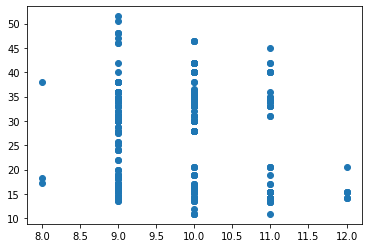

In [4]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

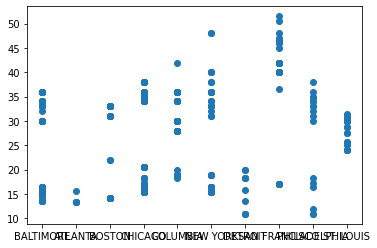

In [5]:
plt.scatter('City','Price',data=new_pumpkins)

Transform Strings to Integer for Mathematical Linear Regression Calculation:

In [20]:
from sklearn.preprocessing import LabelEncoder
new_pumpkins.iloc[:,0:-1] = new_pumpkins.iloc[:,0:-1].apply(LabelEncoder().fit_transform)
new_pumpkins.head()

,Month,Variety,City,Package,Low Price,High Price,Price
70,1,3,1,0,5,3,13.636364
71,1,3,1,0,10,7,16.363636
72,2,3,1,0,10,7,16.363636
73,2,3,1,0,9,6,15.454545
74,2,3,1,0,5,3,13.636364


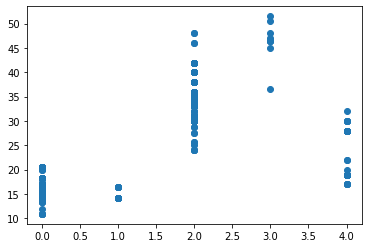

In [22]:
plt.scatter('Package','Price',data=new_pumpkins)

Look at different Correleations to see where linear regression makes sense:

In [7]:
print('Corr, City-Price: ',new_pumpkins['City'].corr(new_pumpkins['Price']))
print('Corr, Package-Price: ',new_pumpkins['Package'].corr(new_pumpkins['Price']))
print('Corr, Month-Price: ',new_pumpkins['Month'].corr(new_pumpkins['Price']))
print('Corr, Variety-Price: ',new_pumpkins['Variety'].corr(new_pumpkins['Price']))



Corr, City-Price:  0.32363971816089215
Corr, Package-Price:  0.6061712937226045
Corr, Month-Price:  -0.14878293554077532
Corr, Variety-Price:  -0.8634790400214394


Building Linear Model:

In [8]:
#Drop null data
new_pumpkins.dropna(inplace=True)
new_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 70 to 1742
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       415 non-null    int64  
 1   Variety     415 non-null    int32  
 2   City        415 non-null    int32  
 3   Package     415 non-null    int32  
 4   Low Price   415 non-null    int64  
 5   High Price  415 non-null    int64  
 6   Price       415 non-null    float64
dtypes: float64(1), int32(3), int64(3)
memory usage: 21.1 KB


In [9]:
#new two column dataframe for linear regression
new_columns = ['Package', 'Price']
lin_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis='columns')

# Assign X and y
X = lin_pumpkins.values[:, :1]
y = lin_pumpkins.values[:, 1:2]



In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
#create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#fit model (run calculation)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
#predict for last 20% (test time)
pred = lin_reg.predict(X_test)

accuracy_score = lin_reg.score(X_train,y_train)
print('Model Accuracy: ', accuracy_score)

Model Accuracy:  0.3315342327998987


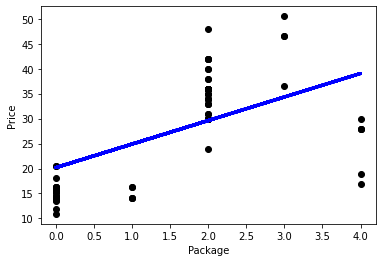

In [11]:
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, pred, color='blue', linewidth=3)

plt.xlabel('Package')
plt.ylabel('Price')

plt.show()

In [12]:
lin_reg.predict( np.array([ [2.75] ]) )

array([[33.15655975]])

Polynomial Regression

In [13]:
new_columns = ['Variety', 'Package', 'City', 'Month', 'Price']
poly_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis='columns')

poly_pumpkins

,Month,Variety,City,Package,Price
70,1,3,1,0,13.636364
71,1,3,1,0,16.363636
72,2,3,1,0,16.363636
73,2,3,1,0,15.454545
74,2,3,1,0,13.636364
...,...,...,...,...,...
1738,1,1,9,2,30.000000
1739,1,1,9,2,28.750000
1740,1,1,9,2,25.750000
1741,1,1,9,2,24.000000


In [14]:
#Correlation Heatmap
corr = poly_pumpkins.corr()
corr.style.background_gradient(cmap='coolwarm')

,Month,Variety,City,Package,Price
Month,1.000000,0.171330,-0.188728,-0.144847,-0.148783
Variety,0.171330,1.000000,-0.248441,-0.614855,-0.863479
City,-0.188728,-0.248441,1.000000,0.301604,0.323640
Package,-0.144847,-0.614855,0.301604,1.000000,0.606171
Price,-0.148783,-0.863479,0.323640,0.606171,1.000000


Create Pipeline

In [15]:
X=poly_pumpkins.iloc[:,3:4].values  # packages
y=poly_pumpkins.iloc[:,4:5].values  # price

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
#create pipeline object with parameters
pipeline = make_pipeline(PolynomialFeatures(4), LinearRegression())
#train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#calculate
pipeline.fit(np.array(X_train), y_train)
#predict
y_pred=pipeline.predict(X_test)

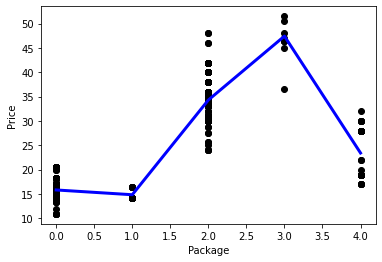

In [17]:
# create dataframe and sort values
df = pd.DataFrame({'x': X_test[:,0], 'y': y_pred[:,0]})
df.sort_values(by='x',inplace = True)
points = pd.DataFrame(df).to_numpy()

#plot
plt.plot(points[:, 0], points[:, 1],color="blue", linewidth=3)
plt.xlabel('Package')
plt.ylabel('Price')
plt.scatter(X,y, color="black")
plt.show()

Accuracy Check:

In [18]:
accuracy_score = pipeline.score(X_train,y_train)
print('Model Accuracy: ', accuracy_score)

Model Accuracy:  0.8537946517073784


Do a prediction

In [19]:
pipeline.predict( np.array([ [2.75] ]) )

array([[46.34509342]])